# The notebook shows the EDA (Exploratory Data Analysis) of the House Price Prediction Problem

## 1. Importing libraries

# Regression techniques

* Linear Regression
* Logistic Regression
* Ridge Regression
* Lasso Regression
* Polynomial Regression
* Bayesian Linear Regression

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

In [10]:
# Importing test and training Dataset
train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

#Combining Training and test set to reduce time.
train_len = len(train)
df_train =  pd.concat(objs=[train, df_test], axis=0).reset_index(drop=True)

In [11]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [12]:
# At first, we do not need the ID column, so we will get rid of it
df_train.drop("Id", axis=1,inplace=True)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


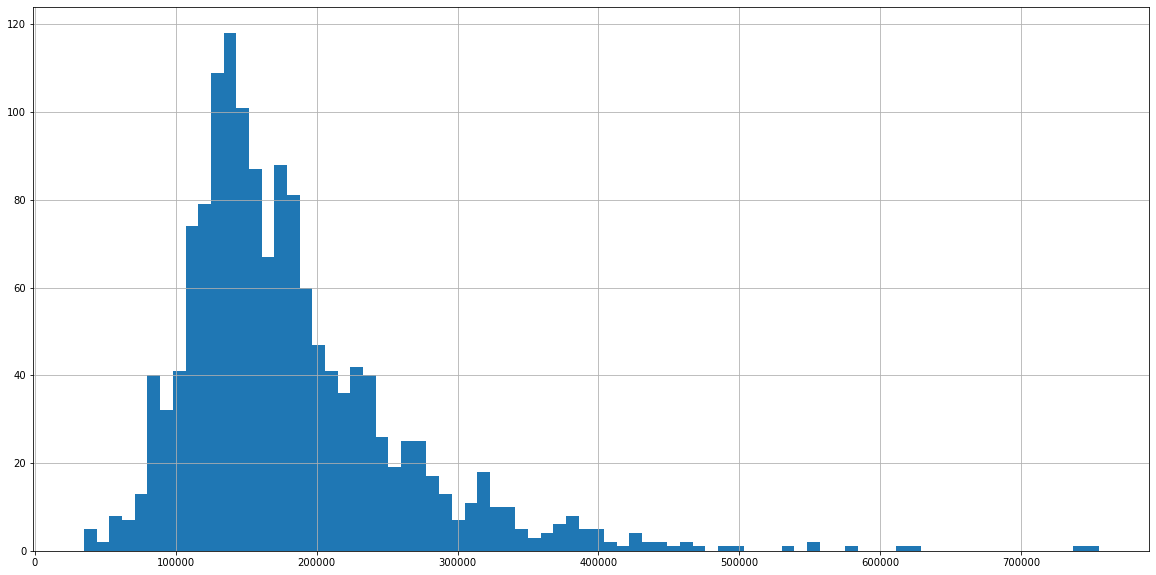

In [13]:
df_train.SalePrice.hist(bins=80, figsize = (20,10));

## Skewness
The `SalePrice` is right skewed. If the histogram is skewed right, the **mean** is greater than the **median**. In case of normal distribution, the mean, median and mode are approximately closer. These three are all measures of the center of a data.

Data skewed to the right is usually a result of a lower boundary in a data set. So if the data set's lower bounds are extremely low relative to the rest of the data, this will cause the data to skew right.

So in skewed data, **the tail** region may act as an **outlier** for the statistical model and we know that outliers adversely affect the model’s performance especially regression-based models. So there is a necessity to transform the skewed data to close enough to a Gaussian distribution or Normal distribution. This will allow us to try more number of statistical model.

### Outlier
An outlier is an observation that lies an abnormal distance from other values in a random sample from a population.

## Solution
To handle the right skewness:
* **logarithms (best for it)**
* roots[square root and cube root] (good)
* reciprocals (weak)

In [14]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

## Correlation
If your dataset has perfectly positive or negative attributes then there is a high chance that the performance of the model will be impacted by a problem called — “Multicollinearity”. Multicollinearity happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can lead to skewed or misleading results. Luckily, decision trees and boosted trees algorithms are immune to multicollinearity by nature. When they decide to split, the tree will choose only one of the perfectly correlated features. However, other algorithms like Logistic Regression or Linear Regression are not immune to that problem and you should fix it before training the model.

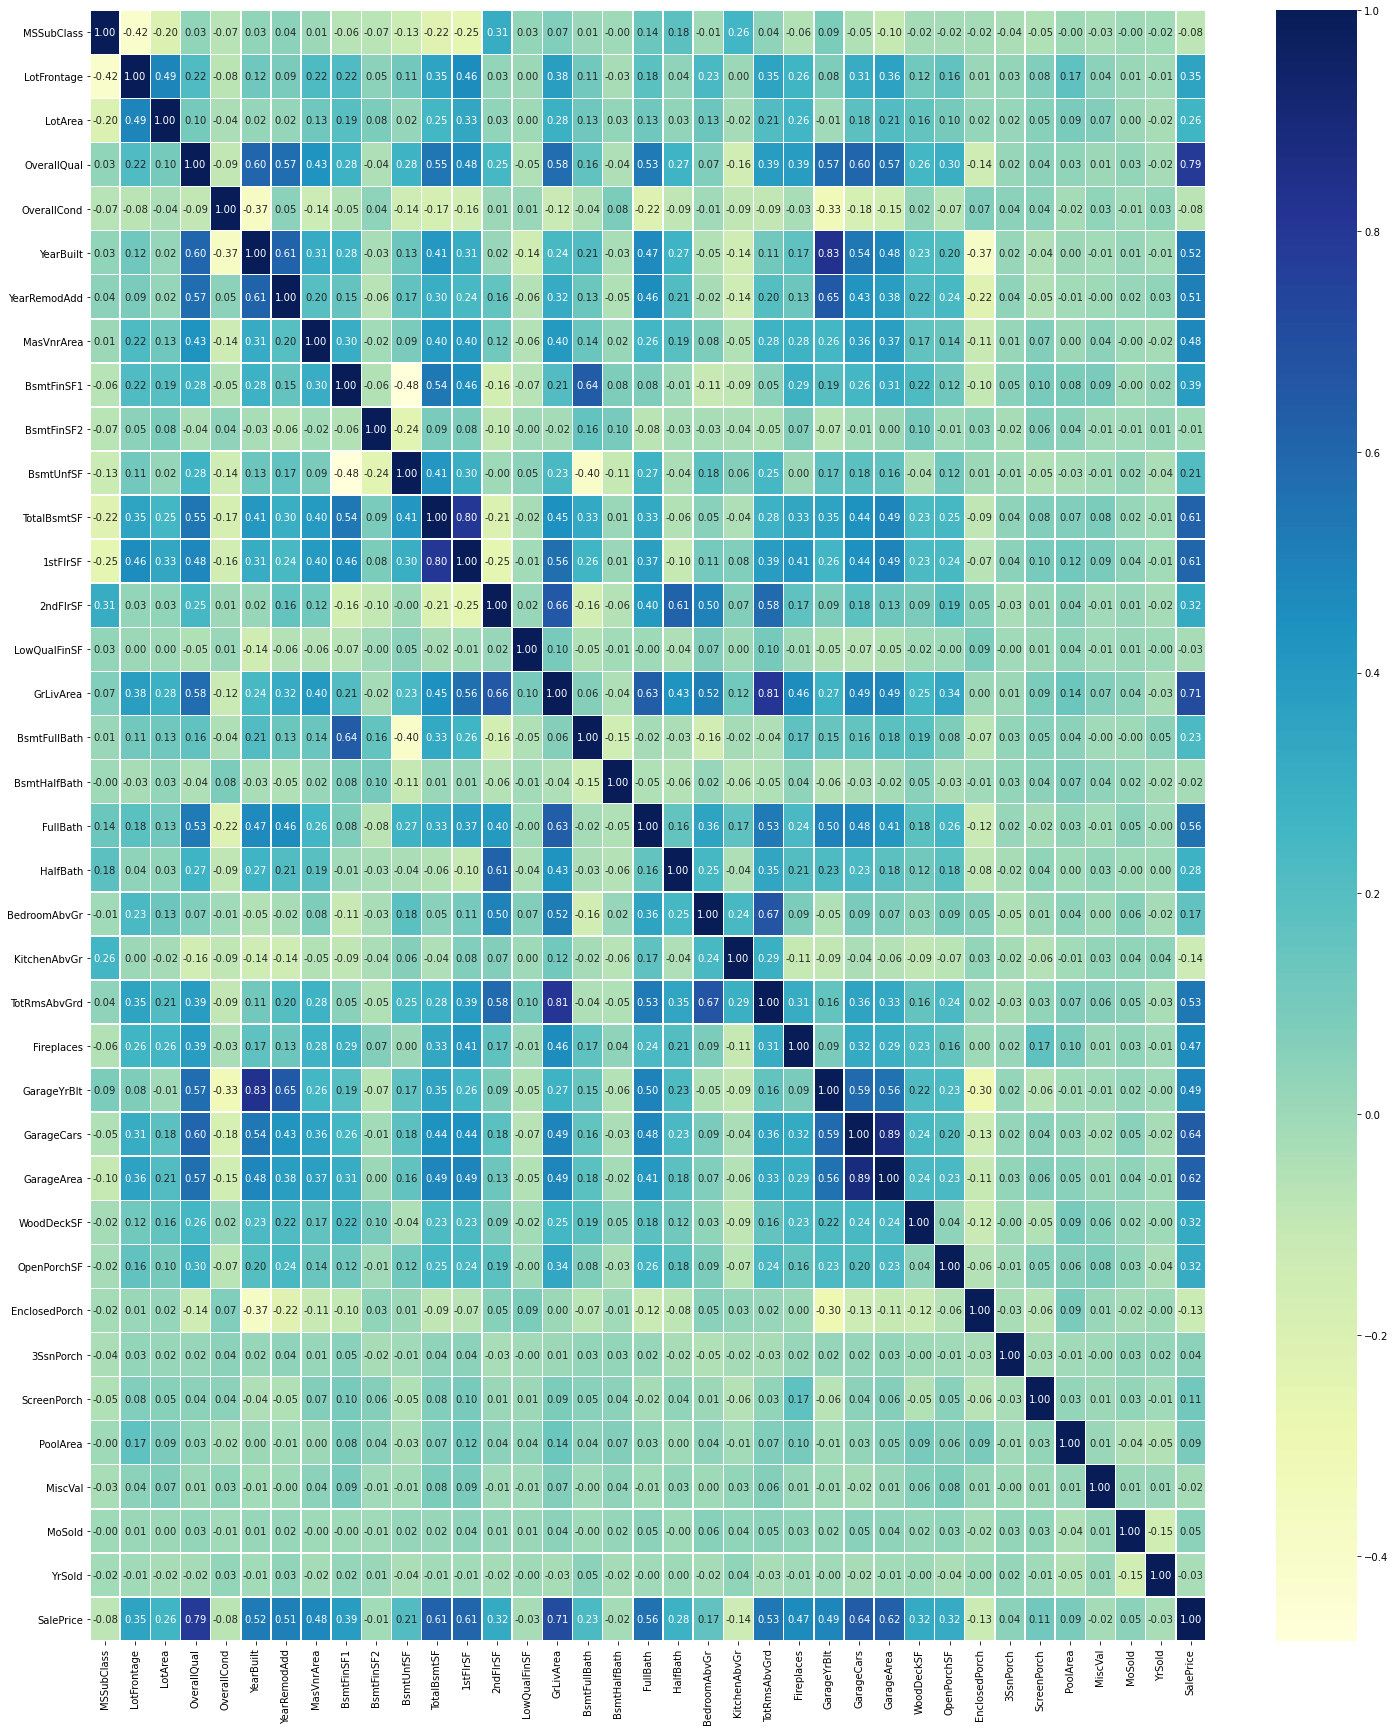

In [15]:
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(25,30))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt="0.2f",
                cmap="YlGnBu");

The `SalePrice` shows a strong positive correlation with the Overall house quality `OverallQual`, the Ground living area `GrLivArea`, the 1st floor area `1stFlrSF` , the basement area `TotalBsmtSF` and the Size of garage `GarageCars` and `GarageArea`.

Let's see in details the most correlated features.

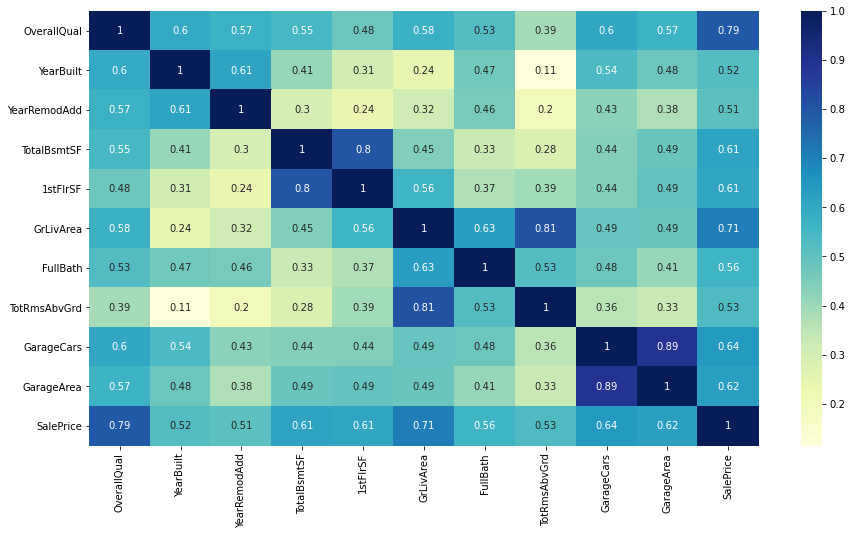

In [16]:
## Top correlated features
top_corr_features = corr_matrix.index[abs(corr_matrix["SalePrice"])>0.5]
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="YlGnBu")

In [17]:
# missing value fillup
df_train["Alley"] = df_train["Alley"].fillna("No")

df_train["MiscFeature"] = df_train["MiscFeature"].fillna("No")

df_train["Fence"] = df_train["Fence"].fillna("No")

df_train["PoolQC"] = df_train["PoolQC"].fillna("No")

df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("No")

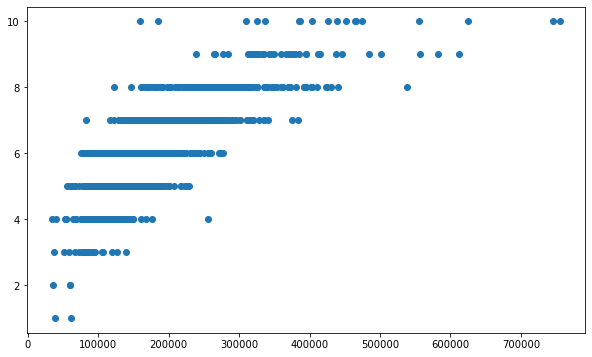

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df_train['SalePrice'], y = df_train['OverallQual'])
plt.show()

In [19]:
df_train.isna().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 80, dtype: int64

## Working with missing values for categorized Data
According to data description, most of the missing values are not missing actually. They are either 0 in quantity or not available, so these are information too. We cannot remove or fill it using other values.

In [20]:
# Utilities has two missing values so its filled with most common value of the feature.
df_train["Utilities"] = df_train["Utilities"].fillna("AllPub")

In [21]:
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("No")
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("No")
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("No")
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("No")
df_train.loc[df_train["BsmtCond"] == "No","BsmtUnfSF"] = 0
df_train.loc[df_train["BsmtFinType1"] == "No","BsmtFinSF1"] = 0
df_train.loc[df_train["BsmtFinType2"] == "No","BsmtFinSF2"] = 0
df_train.loc[df_train["BsmtQual"] == "No","TotalBsmtSF"] = 0
df_train.loc[df_train["BsmtCond"] == "No","BsmtHalfBath"] = 0
df_train.loc[df_train["BsmtCond"] == "No","BsmtFullBath"] = 0
df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("No")

In [22]:
df_train["MSZoning"] = df_train["MSZoning"].fillna("RL")
df_train["KitchenQual"] = df_train["KitchenQual"].fillna("TA")

In [23]:
pd.set_option('display.max_rows', 20)
df_train.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       486
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 80, dtype: int64

In [24]:
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(df_train["LotFrontage"].median())

In [25]:
df_train["GarageType"] = df_train["GarageType"].fillna("No")
df_train["GarageFinish"] = df_train["GarageFinish"].fillna("No")
df_train["GarageQual"] = df_train["GarageQual"].fillna("No")
df_train["GarageCond"] = df_train["GarageCond"].fillna("No")
df_train.loc[df_train["GarageType"] == "No","GarageYrBlt"] = df_train["YearBuilt"][df_train["GarageType"]=="No"]
df_train.loc[df_train["GarageType"] == "No","GarageCars"] = 0
df_train.loc[df_train["GarageType"] == "No","GarageArea"] = 0
df_train["GarageArea"] = df_train["GarageArea"].fillna(df_train["GarageArea"].median())
df_train["GarageCars"] = df_train["GarageCars"].fillna(df_train["GarageCars"].median())
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(df_train["GarageYrBlt"].median())

In [26]:
df_train["Electrical"] = df_train["Electrical"].fillna("SBrkr")
df_train["Functional"] = df_train["Functional"].fillna("Typ")
df_train["Exterior2nd"] = df_train["Exterior2nd"].fillna("VinylSd")
df_train["Exterior1st"] = df_train["Exterior1st"].fillna("VinylSd")

In [27]:
df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_train.loc[df_train["MasVnrType"] == "None","MasVnrArea"] = 0

## Feature transformation

MSSubClass, MoSold and YrSold are not numerical data. Lets make them categorical

In [28]:
df_train = df_train.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
190: 'SubClass_190'}})

In [29]:
df_train = df_train.replace({'MoSold': {1: 'Jan', 2: 'Feb',3: 'Mar',
4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',
11: 'Nov',12: 'Dec'}})

In [30]:
df_train['YrSold'] = df_train['YrSold'].astype(str)

## Categorizing the data

In [31]:
# Find the columns which contains strings
for label, content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

MSSubClass
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
MoSold
YrSold
SaleType
SaleCondition


In [32]:
for label, content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories into numbers and add +1
        df_train[label] = pd.Categorical(content).codes

In [33]:
pd.set_option('display.max_rows', 20)
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,10,3,65.0,8450,1,1,3,3,0,4,...,0,3,4,1,0,3,2,8,4,208500.0
1,5,3,80.0,9600,1,1,3,3,0,2,...,0,3,4,1,0,8,1,8,4,181500.0
2,10,3,68.0,11250,1,1,0,3,0,4,...,0,3,4,1,0,11,2,8,4,223500.0
3,11,3,60.0,9550,1,1,0,3,0,0,...,0,3,4,1,0,3,0,8,0,140000.0
4,10,3,84.0,14260,1,1,0,3,0,2,...,0,3,4,1,0,2,2,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2,4,21.0,1936,1,1,3,3,0,4,...,0,3,4,1,0,6,0,8,4,NaN
2915,2,4,21.0,1894,1,1,3,3,0,4,...,0,3,4,1,0,0,0,8,0,NaN
2916,5,3,160.0,20000,1,1,3,3,0,4,...,0,3,4,1,0,11,0,8,0,NaN
2917,14,3,62.0,10441,1,1,3,3,0,4,...,0,3,2,3,700,5,0,8,4,NaN


## Reduce skewness (Log transformation)

Categorical data are not from a normal distribution.

The normal distribution only makes sense if you're dealing with at least interval data, and the normal distribution is continuous and on the whole real line. If any of those aren't true you don't need to examine the data distribution to conclude that it's not consistent with normality.

The features that are supported to check the normal distribution are listed as `skewed_features`

In [34]:
skewed_features = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GarageArea","MasVnrArea"
                   ,"TotalBsmtSF","1stFlrSF","2ndFlrSF","3SsnPorch","EnclosedPorch",
                   "GrLivArea","LotArea","LowQualFinSF","OpenPorchSF","PoolArea",
                   "ScreenPorch","WoodDeckSF"]

<Figure size 432x288 with 0 Axes>

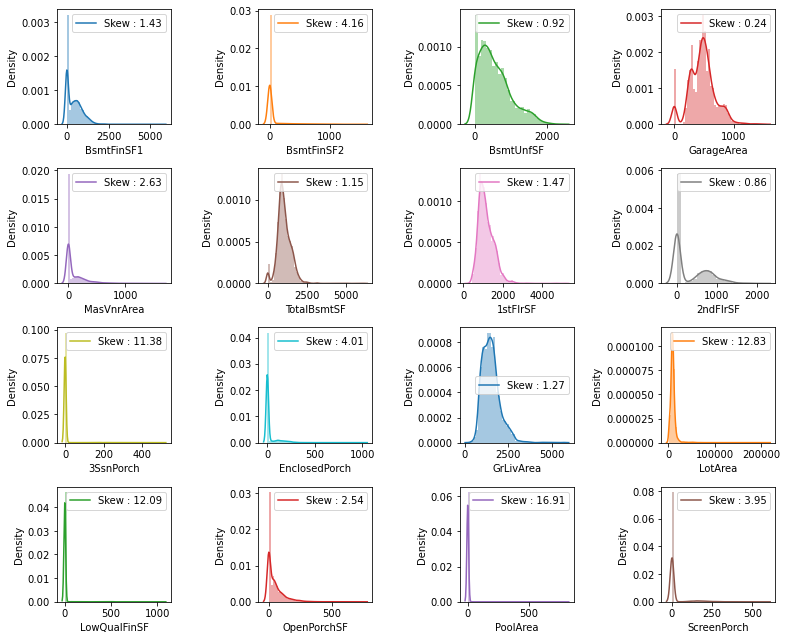

<Figure size 432x288 with 0 Axes>

In [35]:
multiplot(data = df_train,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

In [36]:
for feature in skewed_features:
    df_train[feature] = np.log1p(df_train[feature])

<Figure size 432x288 with 0 Axes>

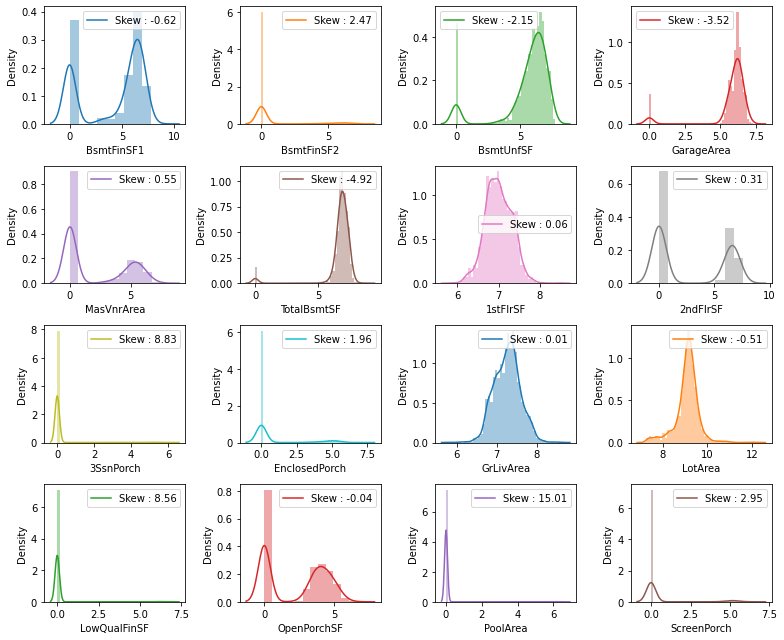

<Figure size 432x288 with 0 Axes>

In [37]:
multiplot(data = df_train,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

<Figure size 432x288 with 0 Axes>

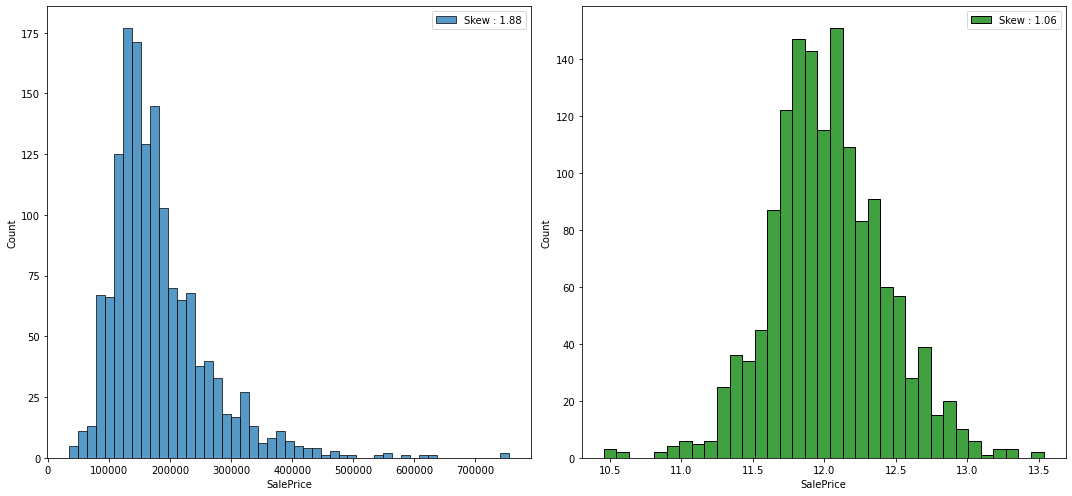

<Figure size 432x288 with 0 Axes>

In [38]:
plt.figure(1);
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.histplot(df_train["SalePrice"],ax = axes[0])
sns.histplot(np.log1p(df_train["SalePrice"]),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(df_train["SalePrice"].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(df_train["SalePrice"].skew()))])

plt.tight_layout()
plt.show()
plt.gcf().clear()

So we have managed to reduce the skewness of the SalePrice feature.

In [39]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
Y = df_train["SalePrice"]
df_train = df_train.drop(labels="SalePrice",axis = 1)

In [40]:
X_train = df_train[:train_len]
test = df_train[train_len:]

Y_train = Y[:train_len]

In [41]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)


In [42]:
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [43]:
RMSE(lassocv, X_train, Y_train)

0.13560739012726658

In [44]:
RMSE(ridge, X_train, Y_train)

0.13567522040375743

In [45]:
RMSE(lassolarscv, X_train, Y_train)

0.1337239789409533

In [46]:
RMSE(elasticnetcv, X_train, Y_train)

0.13570007354892727

In [47]:
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
RMSE(model, X_train, Y_train)

0.14280106545646892

In [48]:
model2 = CatBoostRegressor()
RMSE(model2, X_train, Y_train)

0.1238971100622401

<AxesSubplot:>

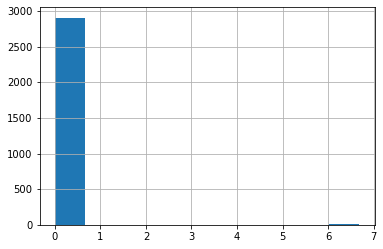

In [49]:
df_train.PoolArea.hist()

In [50]:
pd.set_option('display.max_rows', None)
df_train.PoolArea

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.000000
35      0.000000
36      0.000000
37      0.000000
38      0.000000
39      0.000000
40      0.000000
41      0.000000
42      0.000000
43      0.000000
44      0.000000
45      0.000000
46      0.000000
47      0.000000
48      0.000000
49      0.000000
50      0.000000
51      0.000000
52      0.000000
53      0.000000
54      0.000000
55      0.000000
56      0.000000
57      0.000000
58      0.0000

In [51]:
df_train.PoolArea.value_counts()

0.000000    2906
6.605298       1
4.976734       1
6.685861       1
6.475433       1
6.331502       1
6.175867       1
6.240276       1
5.910797       1
6.253829       1
6.320768       1
5.433722       1
6.357842       1
6.098074       1
Name: PoolArea, dtype: int64